In [41]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras
.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import plot_model, img_to_array

In [3]:
dir_train = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/'
dir_train_def = dir_train+'def_front/'
dir_train_ok = dir_train+'ok_front/'

dir_test = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test/'
dir_test_def = dir_test+'def_front/'
dir_test_ok = dir_test+'ok_front/'

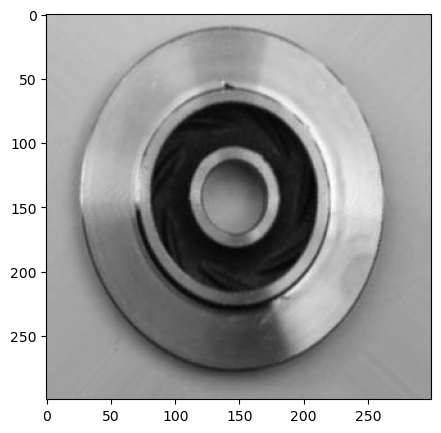

In [4]:
img = plt.imread(dir_train_def+'/cast_def_0_1001.jpeg')
plt.figure(figsize=(5,5))
plt.imshow(img,cmap='gray')

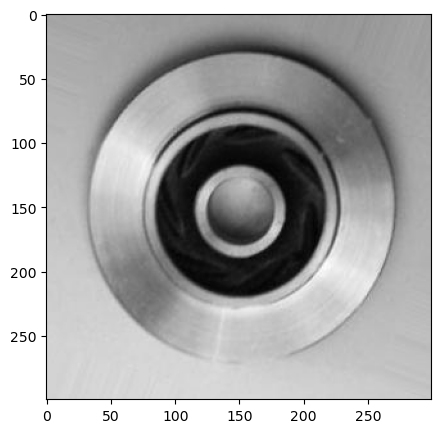

In [5]:
img1 = plt.imread(dir_train_ok + '/cast_ok_0_1001.jpeg')
plt.figure(figsize=(5,5))
plt.imshow(img1,cmap='gray')

In [6]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

image_shape, batch_size, rand_seed = (224, 224, 3), 64, 0
arg_train = {'target_size': image_shape[:2],
             'color_mode': 'rgb',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size}
             #'seed': rand_seed}
arg_test = {'target_size': image_shape[:2],
            'color_mode': 'rgb',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            #'seed': rand_seed,
            'shuffle': False}
            

train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)

valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)

test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [7]:
train_set.class_indices

{'ok_front': 0, 'def_front': 1}

In [8]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(units=224, activation='relu'))

model.add(Dropout(rate=0.2))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

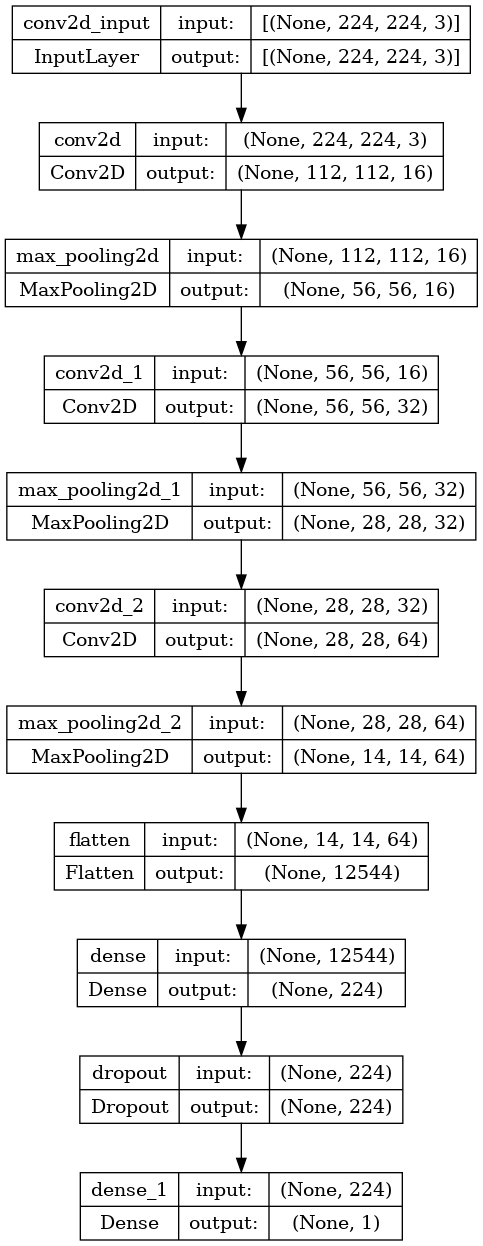

In [10]:
plot_model(model, show_shapes=True)

In [11]:
model_save_path = 'casting_product_detection_normal.hdf5'
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
results = model.fit_generator(train_set,
                              epochs=20,
                              validation_data=valid_set,
                              callbacks=[early_stop, checkpoint])

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.6832
Epoch 1: val_loss improved from inf to 0.39727, saving model to casting_product_detection_normal.hdf5
83/83 [==============================] - 87s 1s/step - loss: 0.5756 - accuracy: 0.6832 - val_loss: 0.3973 - val_accuracy: 0.8416
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8574
Epoch 2: val_loss improved from 0.39727 to 0.23141, saving model to casting_product_detection_normal.hdf5
83/83 [==============================] - 73s 882ms/step - loss: 0.3340 - accuracy: 0.8574 - val_loss: 0.2314 - val_accuracy: 0.9027
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9224
Epoch 3: val_loss improved from 0.23141 to 0.14238, saving model to casting_product_detection_normal.hdf5
83/83 [==============================] - 73s 882ms/step - loss: 0.2037 - accuracy: 0.9224 - val_loss: 0.1424 - val_accuracy: 0.9525
Epoch 4/20


In [13]:
losses = pd.DataFrame(model.history.history)

<Axes: >

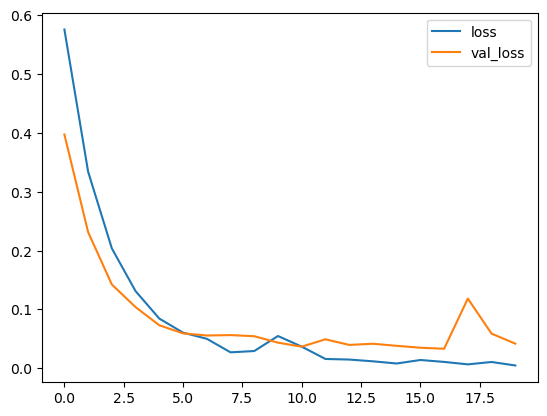

In [14]:
losses[['loss','val_loss']].plot()

<Axes: >

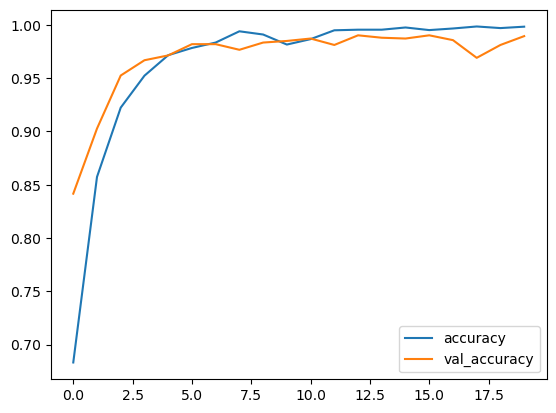

In [15]:
losses[['accuracy','val_accuracy']].plot()

In [16]:
model = load_model('casting_product_detection_normal.hdf5')

In [17]:
y_pred_prob = model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

12/12 [==============================] - 7s 565ms/step


In [18]:
print(classification_report(test_set.classes,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       262
           1       0.99      1.00      0.99       453

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



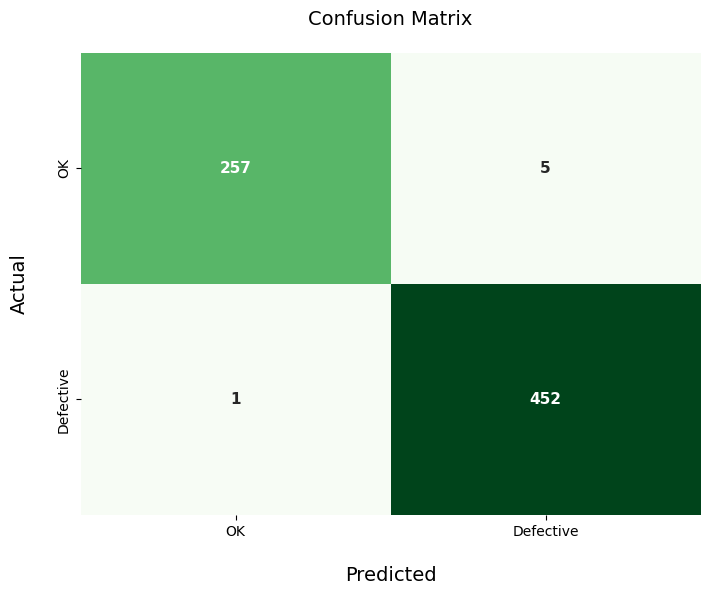

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':11, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Greens')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')

ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

In [20]:
img = cv2.imread(dir_test+'ok_front/cast_ok_0_1020.jpeg')
img = cv2.resize(img, (224, 224))
img = img/255
pred_img =img.copy()

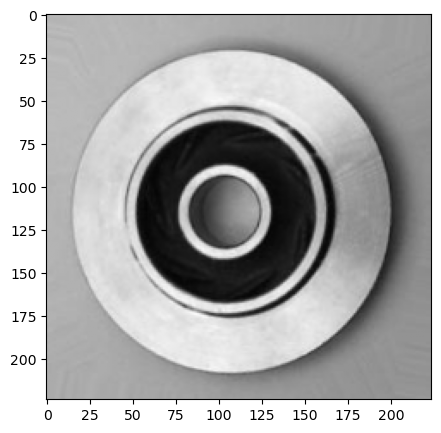

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')

In [22]:
prediction = model.predict(img.reshape(1, *image_shape))
prediction

1/1 [==============================] - 0s 109ms/step


array([[0.00039837]], dtype=float32)

In [23]:
#img = image.load_img(dir_test+'ok_front/cast_ok_0_1020.jpeg',target_size=image_shape)
#img = img_to_array(img)/255
#prediction = vgg16_model.predict(img.reshape(1, *image_shape))

def_front


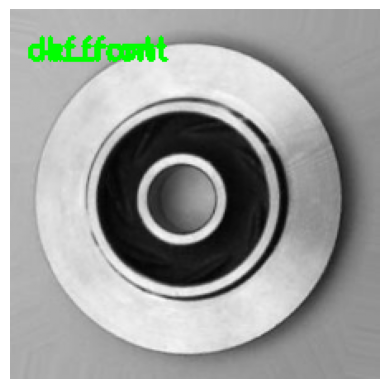

In [33]:
if (prediction<0.5):
    print("ok_front")
    cv2.putText(pred_img, "ok_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("def_front")
    cv2.putText(pred_img, "def_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img,cmap='gray')
plt.axis('off')
plt.show()

In [34]:
img1 = cv2.imread(dir_test+'def_front/cast_def_0_1134.jpeg')
img1 = cv2.resize(img1, (224, 224))
img1 = img1/255
pred_img1 =img1.copy()

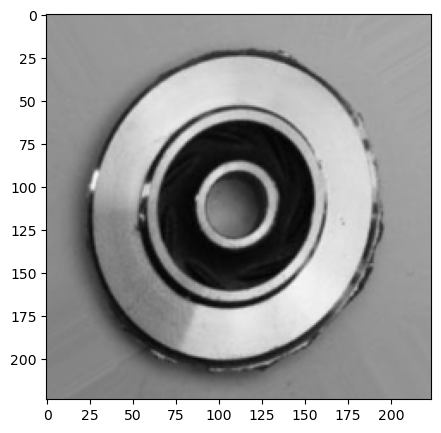

In [35]:
plt.figure(figsize=(5,5))
plt.imshow(img1, cmap='gray')

In [36]:
prediction = model.predict(img1.reshape(1, *image_shape))
prediction

1/1 [==============================] - 0s 30ms/step


array([[1.]], dtype=float32)

def_front


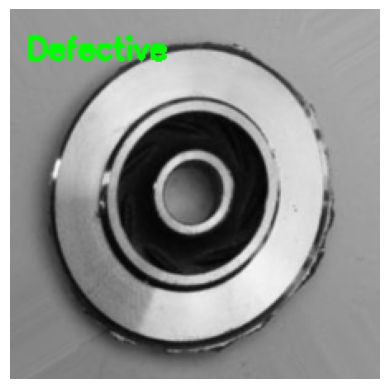

In [37]:
if (prediction<0.5):
    print("ok_front")
    cv2.putText(pred_img1, "Non-defective", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("def_front")
    cv2.putText(pred_img1, "Defective", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img1,cmap='gray')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 29ms/step


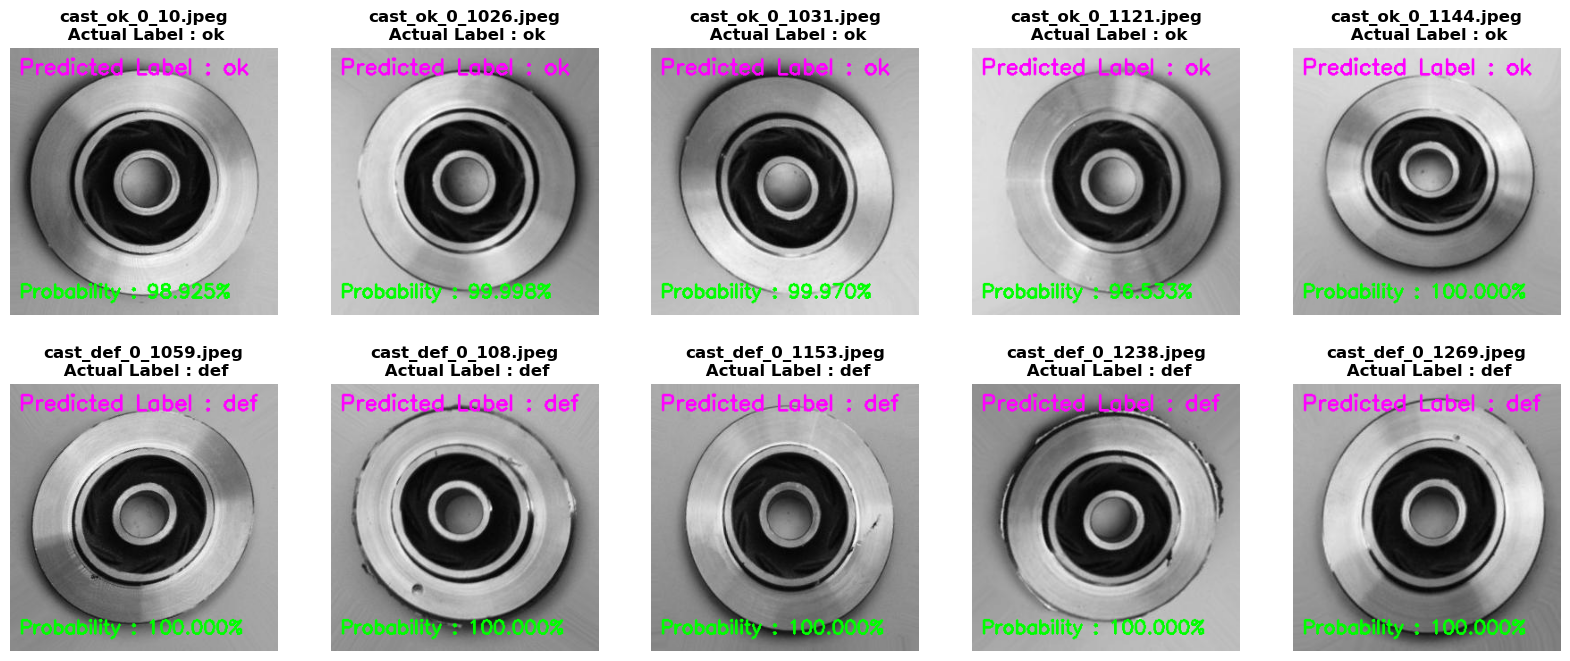

In [38]:
test_cases = ['ok_front/cast_ok_0_10.jpeg', 'ok_front/cast_ok_0_1026.jpeg', 'ok_front/cast_ok_0_1031.jpeg', 'ok_front/cast_ok_0_1121.jpeg', \
              'ok_front/cast_ok_0_1144.jpeg','def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 'def_front/cast_def_0_1153.jpeg',\
              'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg']

plt.figure(figsize=(20,8))
for i in range(len(test_cases)):
    img_pred = cv2.imread(dir_test + test_cases[i])
    img_pred = cv2.resize(img_pred, (224, 224))
    img_pred = img_pred / 255
    prediction = model.predict(img_pred.reshape(1, 224, 224, 3))
    
    img = cv2.imread(dir_test + test_cases[i])
    label = test_cases[i].split("_")[0]
    
    plt.subplot(2, 5, i+1)
    plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)

    if (prediction < 0.5):
        predicted_label = "ok"
        prob = (1-prediction.sum()) * 100

    else:
        predicted_label = "def"
        prob = prediction.sum() * 100
        
    cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
    cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

plt.show()
